# Klasifikasi Deteksi Asap

Model klasifikasi yang akan dibuat merupakan model yang dibuat untuk mengklasifikasikan target fire alarm. Dataset yang digunakan merupakan dataset yang berasal dari Kaggle berjudul "Smoke Detection Dataset" yang dapat diakses pada [link berikut](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset?datasetId=2424784). 

![gambar](https://storage.googleapis.com/kaggle-datasets-images/2424784/4100314/43efb850e636fe8f8719a4801215c180/dataset-cover.jpg?t=2022-08-21-06-30-36)

Detektor asap adalah perangkat yang mendeteksi asap, biasanya sebagai indikator kebakaran dan berbentuk seperti piringan berdiameter sekitar 150 milimeter (6 inci) dan tebal 25 milimeter (1 inci), tetapi bentuk dan ukurannya bervariasi.

## Import Libraries

In [47]:
#Import semua library yang dibutuhkan

import pandas as pd
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
#konfigurasi untuk import dataset dari kaggle
! chmod 600 /content/kaggle.json

In [4]:
#download dataset dengan API kaggle
! kaggle datasets download -d deepcontractor/smoke-detection-dataset

  0% 0.00/1.64M [00:00<?, ?B/s]
100% 1.64M/1.64M [00:00<00:00, 141MB/s]


In [5]:
#membuka file zip
local_file = '/content/smoke-detection-dataset.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('/content/smoke-detection-dataset')
zip_ref.close()

## Data Loading


In [6]:
#deklarasi variabel untuk membaca dataset
ds = pd.read_csv('/content/smoke-detection-dataset/smoke_detection_iot.csv')
ds

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


Dari data yang sudah ter-load, dapat dilihat bahwa data memiliki 16 kolom dan 62630 records. Adapun 16 kolom tersebut diantaranya ialah Unnamed, UTC, Humidity, TVOC, eCO2, Raw H2, Raw Ethanol, Pressure, PM1.0, PM2.5, NC1.0, NC2.5, CNT, dan Fire Alarm







## Deskripsi Variabel


Berdasarkan [sumber dataset](https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6), berikut merupakan deskripsi variabel yang ada:
* Fire Alarm adalah fitur target, dengan kode 1 berarti menandakan ada api
* Temperature adalah suhu dari hasil pengukuran dalam satuan C
* Humidity adalah kelembaban dalam satuan %
* TVOC adalah Total Volatile Organic Compounds dalam satuan per billions 
* eCO2 adalah konsentrasi CO2 dengan memiliki perhitungan nilai yang berbeda dari TVCO
* Raw H2 adalah hidrogen mentah yang tidak terkompensasi dari bias atau temperatur
* Raw Ethanol adalah gas ethanol mentah
* Pressure adalah tekanan udara (Air Pressure)
* PM 1.0 adalah ukuran partikulat dengan range nilai ukur < 1.0 µm 
* PM 2.5 adalah ukuran partikulat dengan range ukur 1.0 µm < 2.5 µm
* CNT adalah sampel penghitungan
* UTC adalah timestamp untuk detik UTC
* NC0.5/NC1.0 and NC2.5 adalah besaran konsentrasi partikulat yang berbeda dari PM karena NC memberikan nilai aktual partikel udara. NC memiliki range ukuran < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); dan 1.0 µm < 2.5 µm (NC2.5);



In [53]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


* Terdapat 6 kolom data numerik tipe data int64 yaitu UTC, TVOC, eCO2, Raw H2, Raw Ethanol, dan CNT yang merupakan data numerik hasil pengukuran sensor
* Terdapat 8 kolom data numerik tipe data float64 yaitu Temperature, Humidity, Pressure, PM1.0, PM2.5, NC0.5, NC1.0, dan NC2.5 yang merupakan data numerik hasil pengukuran sensor
* Terdapat 1 kolom numerik dengant ipe data int64 yaitu Fire Alarm yang mana merupakan fitur target

### Data Cleaning

In [14]:
#pengecekan apakah data memiliki value kosong
print("Cek Data \n")
print(ds.isnull().sum())

print("\n Gambar 1. Cek Data")

Cek Data 

Unnamed: 0        0
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

 Gambar 1. Cek Data


### Numerical Features

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


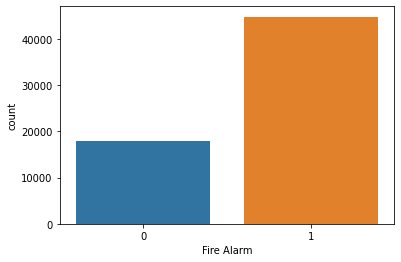

In [22]:
#menghitung banyaknya label pada fitur target Fire Alarm
sns.countplot(ds['Fire Alarm'])

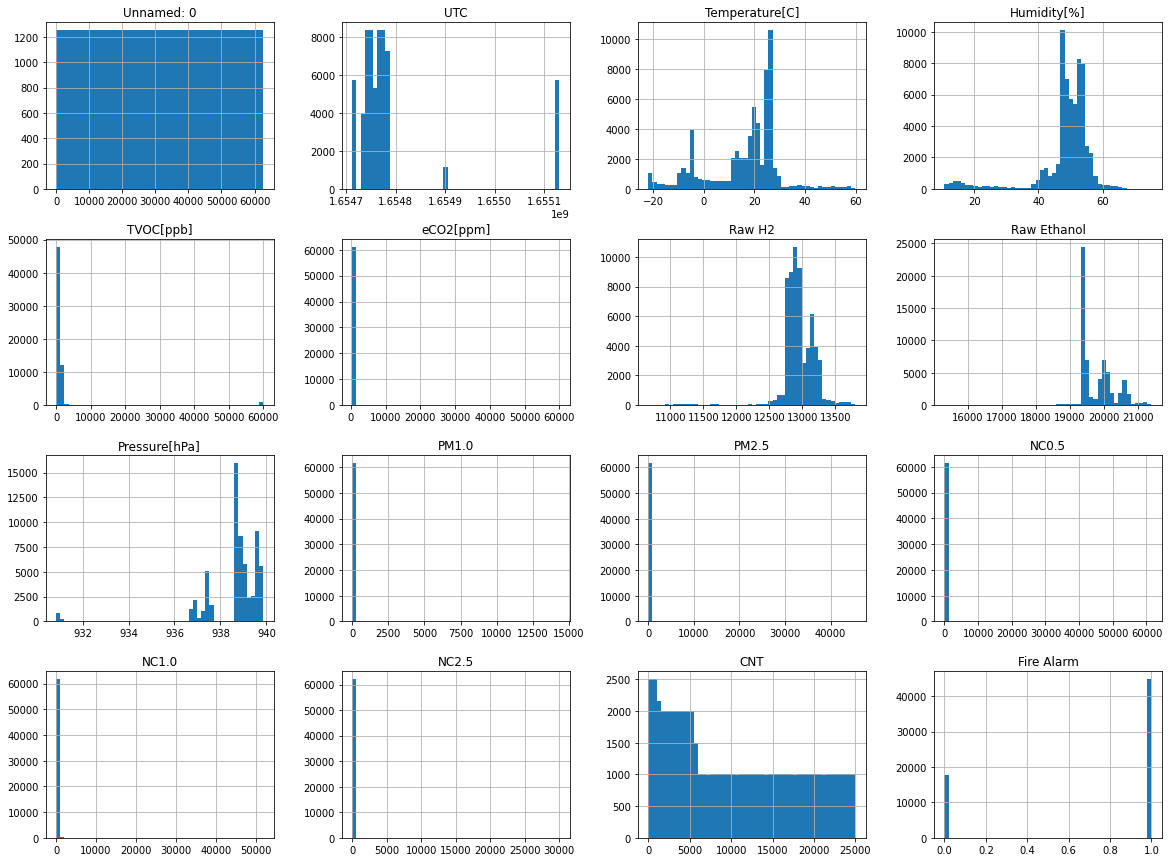

In [52]:
ds.hist(bins=50, figsize=(20,15))
plt.show()

Dari visualisasi data numerik yang dilakukan didapatkan beberapa informasi yaitu:
* Fitur target memiliki dua target yaitu 1 dan 0 dengan jumlah 1 lebih banyak daripada 0
* Dari banyaknya fitur, hanya CNT yang memiliki nilai (value tidak 0) di setiap hampir semua datanya. Hal ini mungkin akan berpengaruh pada model.

## Pra-processing Dataset
Pada tahap ini akan dilakukan seleksi fitur dan normalisasi data

In [23]:
#Split data ke training set dan testing set
X = ds.iloc[:,1:15] #menghilangkan kolom unnamed karena itu tidak berguna
Y = ds.iloc[:,-1]

x_train, x_test,y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
print(x_train.shape)
print(x_test.shape)

(56367, 14)
(6263, 14)


In [24]:
#scaling fitur dari data
standar = StandardScaler()
x_train = standar.fit_transform(x_train)
x_test = standar.transform(x_test)
pd.DataFrame(x_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04,5.636700e+04
mean,4.879011e-13,-3.201835e-17,-9.771901e-16,-1.865636e-17,-7.941560e-18,1.872254e-15,2.145986e-15,-2.957708e-14,-5.042260e-19,4.033808e-18,-1.210143e-17,-1.008452e-18,-3.529582e-18,-6.605361e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-7.261942e-01,-2.639866e+00,-4.263847e+00,-2.484343e-01,-1.410816e-01,-8.338736e+00,-7.280331e+00,-5.844934e+00,-1.092002e-01,-9.333661e-02,-1.155264e-01,-9.190977e-02,-7.377116e-02,-1.382893e+00
25%,-4.433116e-01,-3.474666e-01,-1.144749e-01,-2.320579e-01,-1.410816e-01,-4.121591e-01,-5.233900e-01,5.361752e-02,-1.077973e-01,-9.265684e-02,-1.134416e-01,-9.128148e-02,-7.374064e-02,-9.070171e-01
50%,-2.733471e-01,2.906691e-01,1.810226e-01,-1.229241e-01,-1.410816e-01,-6.752529e-02,-4.150952e-01,1.408030e-01,-1.072318e-01,-9.238290e-02,-1.125968e-01,-9.103026e-02,-7.373047e-02,-1.546101e-01
75%,-1.309450e-01,6.580901e-01,5.295293e-01,-9.631233e-02,-1.213223e-01,6.107433e-01,5.333050e-01,5.940174e-01,-1.069164e-01,-9.223071e-02,-1.121332e-01,-9.089129e-02,-7.372399e-02,8.782071e-01
max,3.079307e+00,3.058880e+00,3.006295e+00,7.428033e+00,3.084977e+01,3.155167e+00,2.717251e+00,9.262243e-01,1.547880e+01,2.295418e+01,1.435202e+01,2.340767e+01,2.769718e+01,1.903529e+00


## Training Model
Model yang akan dibuat menggunakan algoritma K-Nearest Neighbor, Support Vector Machine, dan Random Forest

### K-Nearest Neighbors

In [25]:
knn = KNeighborsClassifier(n_neighbors=43)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=43)

In [26]:
#akurasi train set dan test set
knn_train_acc = accuracy_score(y_train, knn.predict(x_train))
print("Akurasi data training adalah: ", knn_train_acc)
knn_test_acc = accuracy_score(y_test, knn.predict(x_test))
print("Akurasi data testing adalah: ", knn_test_acc)

Akurasi data training adalah:  0.9992371422995724
Akurasi data testing adalah:  0.9995209963276385


In [27]:
#memprediksi test set
cm_knn_2=confusion_matrix(y_test, knn.predict(x_test))

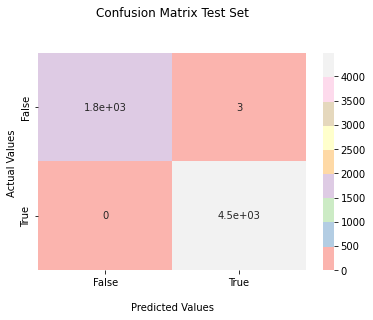

In [28]:
cm = sns.heatmap(cm_knn_2, annot=True, cmap='Pastel1')

#mengatur titel
cm.set_title('Confusion Matrix Test Set\n\n');
cm.set_xlabel('\nPredicted Values')
cm.set_ylabel('Actual Values ');

#mengatur label x dan y 
cm.xaxis.set_ticklabels(['False','True'])
cm.yaxis.set_ticklabels(['False','True'])

plt.show()

### Support Vector Machine

In [29]:
svm = SVC(C=1,kernel='rbf')
svm.fit(x_train,y_train)

SVC(C=1)

In [30]:
svm_train_acc = accuracy_score(y_train, svm.predict(x_train))
print("Akurasi data training adalah: ", svm_train_acc)
svm_test_acc = accuracy_score(y_test, svm.predict(x_test))
print("Akurasi data testing adalah: ", svm_test_acc)

Akurasi data training adalah:  0.9996806642184257
Akurasi data testing adalah:  0.9998403321092129


In [31]:
#memprediksi test set
cm_svm_2=confusion_matrix(y_test, svm.predict(x_test))

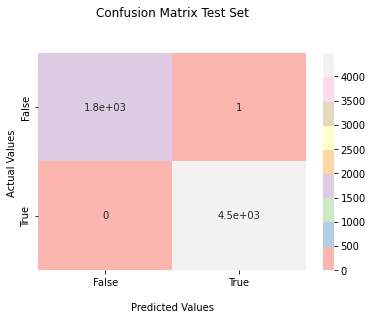

In [32]:
cm = sns.heatmap(cm_svm_2, annot=True, cmap='Pastel1')

#mengatur titel
cm.set_title('Confusion Matrix Test Set\n\n');
cm.set_xlabel('\nPredicted Values')
cm.set_ylabel('Actual Values ');

#mengatur label x dan y 
cm.xaxis.set_ticklabels(['False','True'])
cm.yaxis.set_ticklabels(['False','True'])

plt.show()

### Random Forest

In [33]:
rf= RandomForestClassifier(n_estimators= 100, n_jobs = -1, random_state = 30)
rf.fit(x_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=30)

In [39]:
#akurasi train set dan test set
rf_train_acc = accuracy_score(y_train, rf.predict(x_train))
print("Akurasi data training adalah: ", rf_train_acc)
rf_test_acc = accuracy_score(y_test, rf.predict(x_test))
print("Akurasi data testing adalah: ", rf_test_acc)

Akurasi data training adalah:  1.0
Akurasi data testing adalah:  1.0


In [40]:
#memprediksi test set
cm_rf_2=confusion_matrix(y_test, rf.predict(x_test))

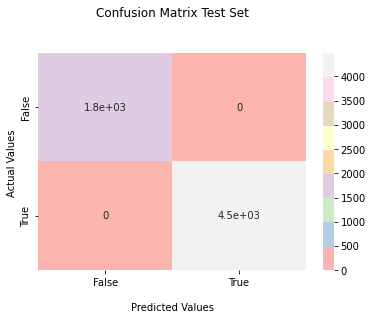

In [41]:
cm = sns.heatmap(cm_rf_2, annot=True, cmap='Pastel1')

#mengatur titel
cm.set_title('Confusion Matrix Test Set\n\n');
cm.set_xlabel('\nPredicted Values')
cm.set_ylabel('Actual Values ');

#mengatur label x dan y 
cm.xaxis.set_ticklabels(['False','True'])
cm.yaxis.set_ticklabels(['False','True'])

plt.show()

## Model Evaluation

### Perbandingan Akurasi Model

In [34]:
#variabel dataframe nilai akurasi data train dan test pada masing-masing algoritma
acc = pd.DataFrame(columns=['train', 'test'], index=['KNN','SVM', 'RF'])
 
#dictionary untuk setiap algoritma yang digunakan
model_dict = {'KNN': knn, 'SVM': svm, 'RF':rf}

#akurasi masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
  acc.loc[name, 'train'] = accuracy_score(y_true=y_train, y_pred=model.predict(x_train))
  acc.loc[name, 'test'] = accuracy_score(y_true=y_test, y_pred=model.predict(x_test))

In [36]:
#memanggil nilai perbandingan akurasi
acc

,train,test
KNN,0.999237,0.999521
SVM,0.999681,0.99984
RF,1.0,1.0


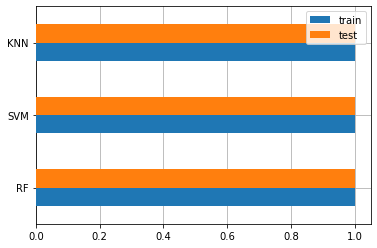

In [37]:
#plot grafik
fig, ax = plt.subplots()
acc.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

### Perbandingan MAE (Mean Absolute Error)

In [50]:
#variabel dataframe nilai akurasi data train dan test pada masing-masing algoritma
mae = pd.DataFrame(columns=['train', 'test'], index=['KNN','SVM', 'RF'])
 
#dictionary untuk setiap algoritma yang digunakan
model_dict = {'KNN': knn, 'SVM': svm, 'RF':rf}

#mae masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
  mae.loc[name, 'train'] = mean_absolute_error(y_true=y_train, y_pred=model.predict(x_train))
  mae.loc[name, 'test'] = mean_absolute_error(y_true=y_test, y_pred=model.predict(x_test))

In [51]:
mae

,train,test
KNN,0.000763,0.000479
SVM,0.000319,0.00016
RF,0.0,0.0


Dari perbandingan yang sudah dilakukan dapat dilihat bahwa algoritma Random Forest merupakan algoritma terbaik untuk mengklasifikasikan dataset Fire Alarm karena memiliki akurasi 100% dibandingkan Support Vector Machine dan K-Nearest Neighbor. Algoritma terbaik kedua yaitu Support Vector Machine karena meskipun memiliki nilai akurasi yang sama seperti K-Nearest Neighbor, akan tetapi ketika dilihat dari nilai MAE kedua algoritma tersebut, dapat dilihat bahwa nilai MAE SVM lebih kecil dibandingkan KNN sehingga SVM bisa dikatakan lebih baik dari KNN. Kesimpulan dari perbandingan algoritma ini yaitu tingkat akurasi terbaik ialah:
* Random Forest
* Support Vector Machine
* K-Nearest Neighbor